In [1]:
import pandas as pd      
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost
import warnings
warnings.filterwarnings('ignore')
import time

In [2]:
df = pd.read_pickle('../2. EDA/data_cleaned')

In [3]:
target_col = ['Price'] 

features_cols = ['Make', 'Milage', 'Year', 'Power', 'Consumption', 'Cylinder',
       'Gears', 'Fuel Type', 'Transmission', 'Body type', 'CO2 emission',
       'Door', 'Seat', 'Engine size', 'data_source', 'Model_1']

In [4]:
def data_stratification(df_, grp_col, n_grp):
    
    '''to divide data in stratified chunks.
    Remaining data to put very last chunk.
    
    Parameters: df_:dataframe
                grp_col: field to get proportions
                n_grp: number of desired group
            
    Return: the index numbers of each group within a dictionary
    
    '''
    
    idx_dict = {}
    n = n_grp

    for i in range(n_grp):

        idx=[]  

        for grp in df_[grp_col].unique():

            data = df_[df_[grp_col]==grp]
            num_data = len(data)//(n_grp)
            pro_data = len(data)/(n_grp)
            
            if n_grp > 1:

                if num_data >= 1:
                    idx.append(list(data.sample(num_data, replace=True).index))

                elif (pro_data <= 1) & (pro_data > 0):
                    idx.append(list(data.sample(1, replace=True).index))

            elif n_grp == 1:
                idx.append(list(data.index))

        idx = list(set([col for row in idx for col in row]))    
        idx_dict[i+1] = idx   
        n_grp -= 1
        df_.drop(index=idx, inplace=True)
    
    idx_dict[0] = idx_dict[n]
    idx_dict.pop(n, None)
    idx_dict = dict(sorted(idx_dict.items()))
    
    return idx_dict

In [5]:
def eval_metrics(actual, pred):
    '''to evaluate performance of regression model
    
    Parameters: actual: actual values
                pred: predicted value
                
    Return: pandas series of evaluations metrics of ML model            
    '''
    
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    a = pd.DataFrame({'actual': actual, 'pred': pred})
    per_mae = np.mean(abs(a.actual - a.pred)/a.actual * 100)
    mse = mean_squared_error(actual, pred)
    r_score = r2_score(actual, pred)
    corr = a.actual.corr(a.pred)
    
    data = pd.Series([r_score, mae, per_mae, mse, rmse, corr], 
                     index=['R2 score', 'MAE', '% of MAE', 'MSE', 'RMSE', 'Correlation'])
    return data.round(3)

In [6]:
def act_pred_data(actual, pred):
    '''create a df with actual, predicted and % of errors
    
    Parameters: actual: str: actual values
                pred: str: predicted values
    Returns a df
    '''
    a = pd.DataFrame({'actual': actual, 'pred': pred})
    a['per_err'] = abs(a.actual - a.pred)/a.actual * 100
    
    return a

In [7]:
def scatter_corr(actual, pred, df):
    '''to draw a scatter plot of actual values vs predicted value with correlation of them
    Parameters: actual: str: actual values
                pred: str: predicted values
                df: dataframe
    
    Return: scatter plot of actual value vs predicted value
    '''
    correlation = df[actual].corr(df[pred])
    
    x = [i for i in range(int(np.min(df[actual])), int(np.max(df[actual])))]
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=actual, y=pred, data=df)
    plt.plot(x, x, color='black')
    plt.plot(np.unique(df[actual]), np.poly1d(np.polyfit(df[actual], df[pred], 1))
             (np.unique(df[actual])), color='red')
    plt.title(f'Correlation of Actual vs Predicted values: {correlation:.2f}', 
              fontdict={'size':18, 'color':'darkred'})
    plt.xlabel('Actual Values', fontdict={'size':15, 'color':'black'})
    plt.ylabel('Predicted Values',fontdict={'size':15, 'color':'black'})

In [8]:
def concat_data(grp):
    '''concatenates new data points into model data
    
    Parameters: grp: groups from idx_grp dictionary
    
    '''
    idx = idx_grp[grp]
    
    global df
    df_n = df.loc[idx]
    
    global data
    data = pd.concat([data, df_n])
    
    #return data

In [9]:
def slide(grp):
    
    idx = idx_grp[grp]
    sliding_window = len(idx)
      
    global data

    idx_del = list(data[0:sliding_window].index)
    
    data = data.drop(index=idx_del)

    df_n = df.loc[idx]

    data = pd.concat([data, df_n])

    

In [10]:
def split_data():
    '''splits data into train test split
    '''
    
    global data
    X = pd.get_dummies(data[features_cols])
    y = data['Price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    return X_train, X_test, y_train, y_test
    
    

In [11]:
def modelling():
    
    global X_train, X_test, y_train, y_test
    
    xgb_model = xgboost.XGBRegressor().fit(X_train, y_train)
        
    return xgb_model

In [12]:
def pred_values(model):
    
    global X_test
    
    y_pred = model.predict(X_test)
    
    return y_pred
    

# Experiments

**Data Chunks**

In [13]:
df_ = df[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

In [14]:
idx_grp = data_stratification(df_, 'Group', 18)

In [15]:
# keys: order of data chunk, values: index of data points
idx_grp

{0: [32770,
  32772,
  98316,
  65551,
  98319,
  98320,
  32786,
  98324,
  21,
  32792,
  32798,
  65567,
  32,
  65570,
  98341,
  38,
  65574,
  65580,
  32820,
  65589,
  65591,
  98361,
  65599,
  32831,
  65602,
  70,
  65609,
  32843,
  32849,
  32850,
  32851,
  65622,
  87,
  98392,
  65628,
  93,
  94,
  98399,
  98400,
  104,
  98408,
  32877,
  98414,
  65647,
  32881,
  65659,
  98428,
  32893,
  32894,
  32895,
  98434,
  98439,
  137,
  138,
  98441,
  98447,
  144,
  146,
  147,
  148,
  155,
  156,
  157,
  158,
  32923,
  172,
  32940,
  174,
  32943,
  180,
  32959,
  65729,
  65732,
  202,
  65738,
  204,
  65740,
  65751,
  216,
  65753,
  65759,
  224,
  98528,
  98531,
  32999,
  98536,
  65772,
  237,
  65777,
  98545,
  33016,
  249,
  252,
  65789,
  257,
  33027,
  33029,
  263,
  65800,
  98568,
  98567,
  33039,
  98577,
  33042,
  65811,
  278,
  98592,
  65830,
  33067,
  98608,
  306,
  65843,
  65848,
  65857,
  33095,
  328,
  65864,
  33096,
  98635,

## Experiment 1

17 data chunks will be concatenated one by one in each iteration to observe how model performance chages when the the data inflated overtime.

In [16]:
data = pd.DataFrame()

for grp in idx_grp.keys():
    
    concat_data(grp)
    X_train, X_test, y_train, y_test = split_data()
    start = time.time()
    model = modelling()
    end = time.time()
    y_pred = pred_values(model)
    globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
    globals()[f'time_{grp}'] = end - start
    globals()[f'size_{grp}'] = len(data)
        

In [17]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp1 = pd.concat([exp_res, a])

df_scores_exp1.rename(columns=cols, inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

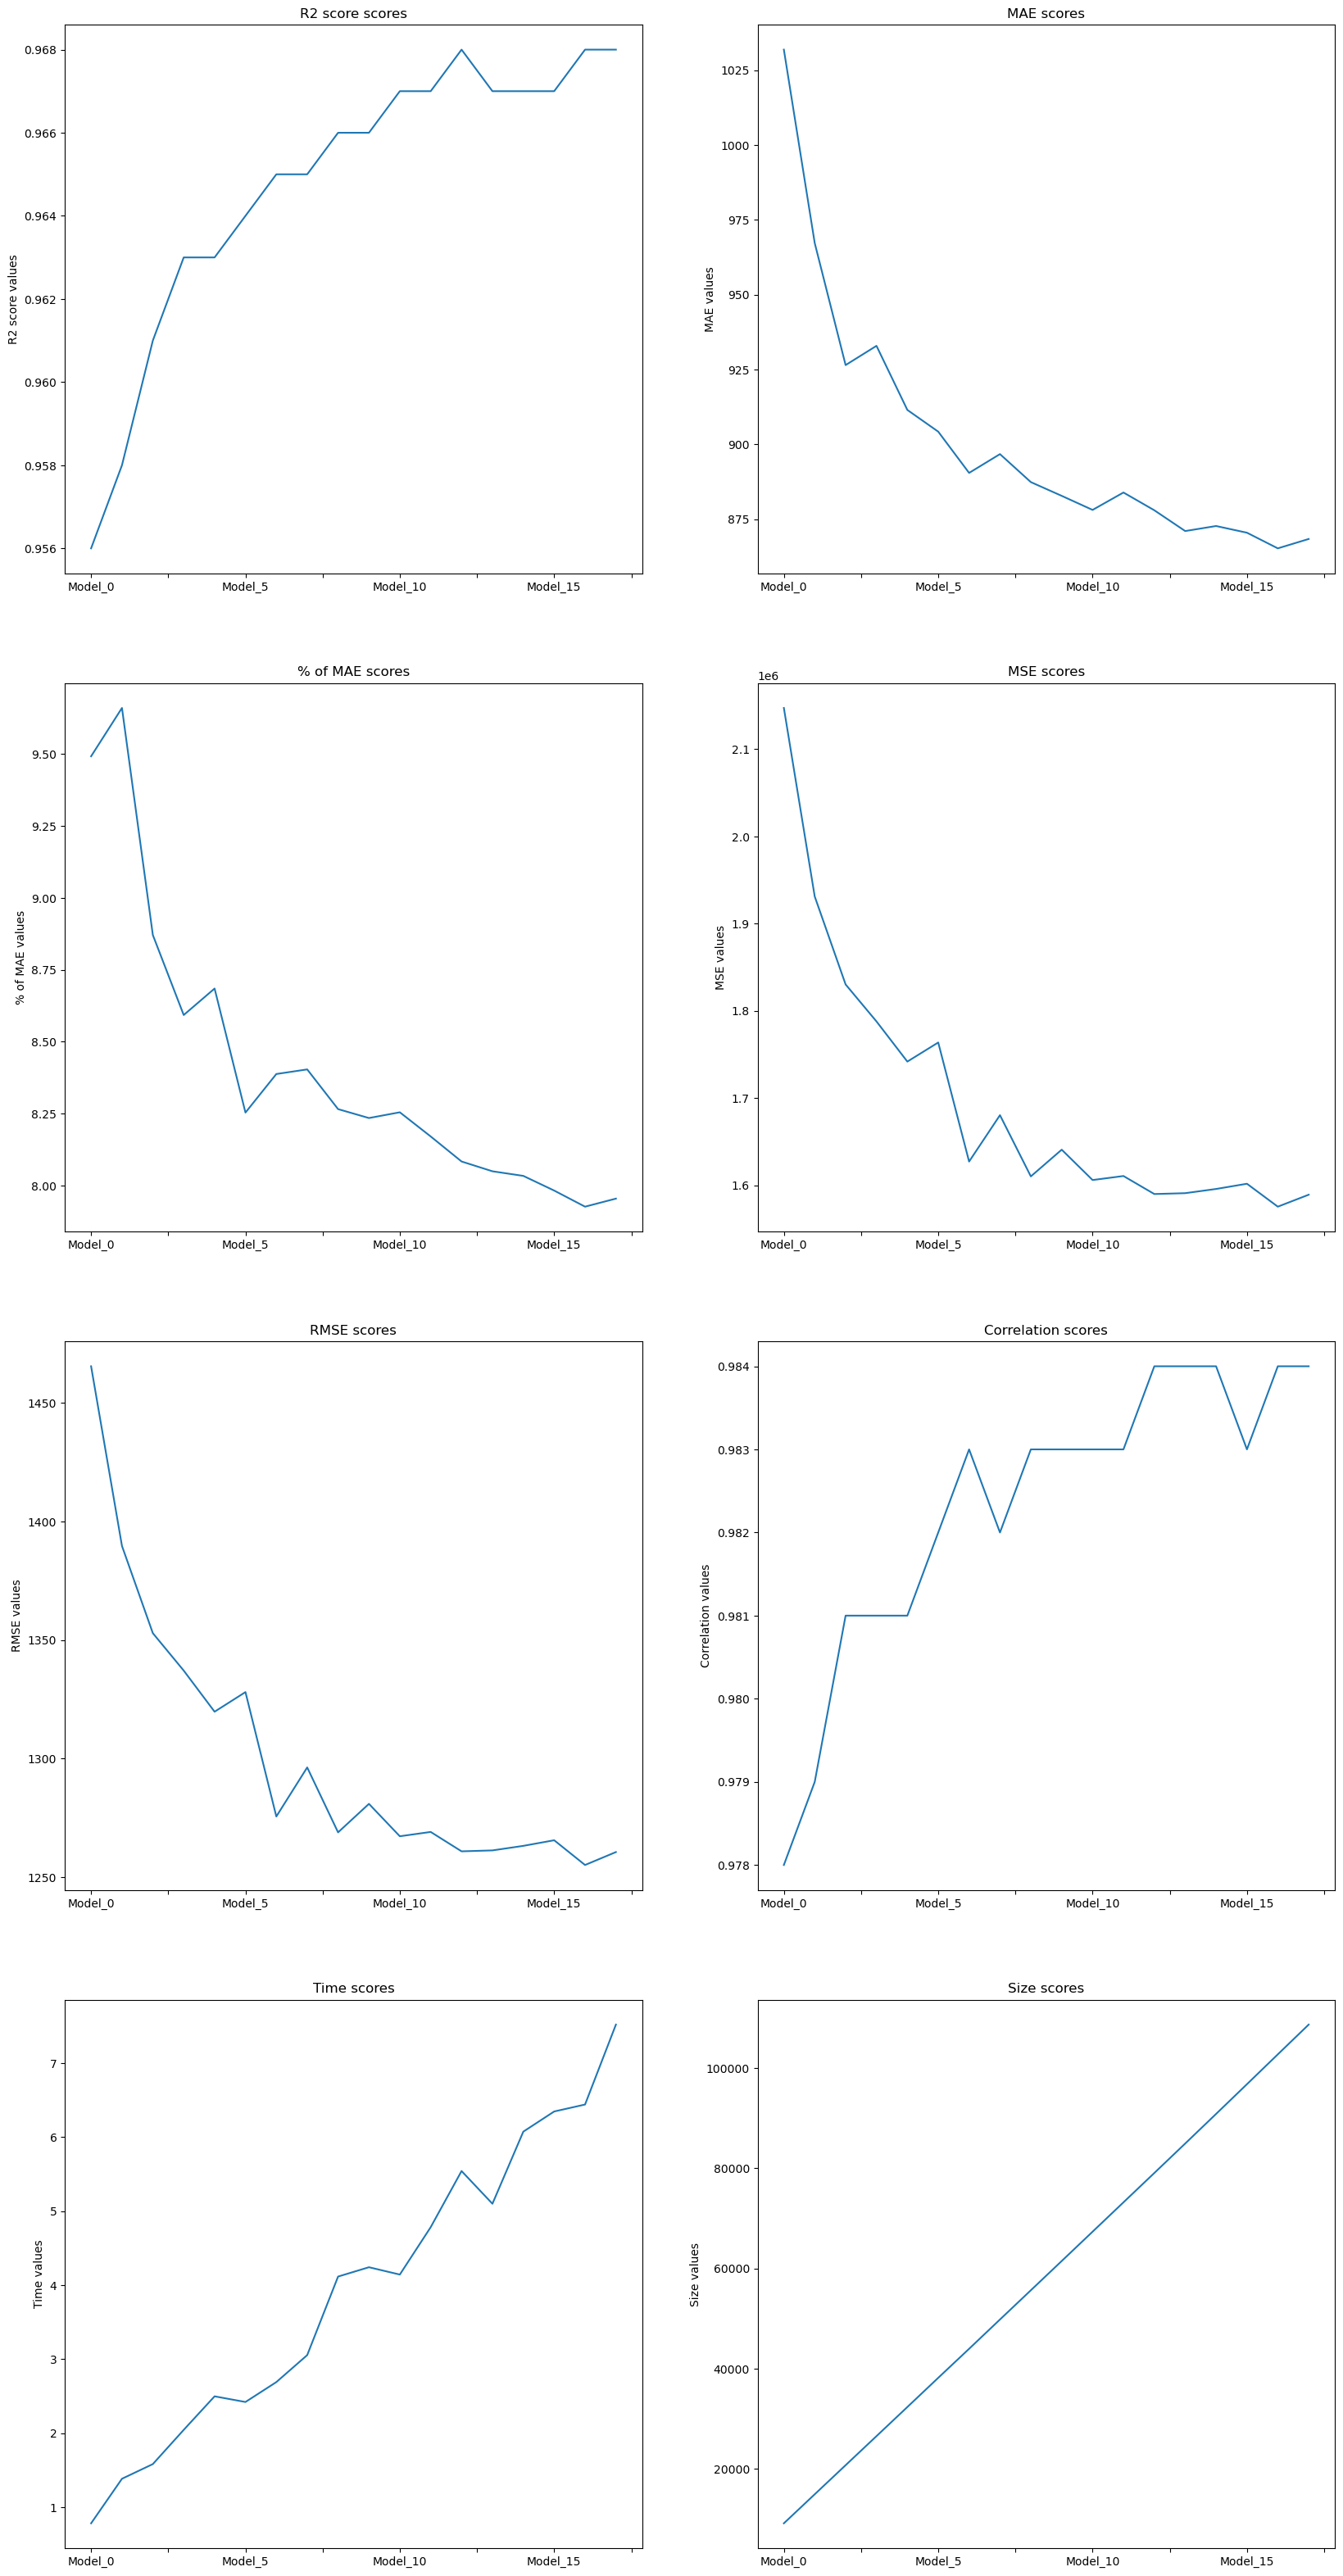

In [18]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp1.index):
    plt.subplot(4,2,i+1)
    df_scores_exp1.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [19]:
df_scores_exp1.to_excel('exp1_scores.xlsx')

## Experiment 2

In this experiment I will keep amount of data constant after a certain threshold. This will be test of classic sliding window approach.

In [20]:
data = pd.DataFrame()

for grp in idx_grp.keys():
          
    if len(data) < 70000:
        concat_data(grp)
    else:
        slide(grp)

    X_train, X_test, y_train, y_test = split_data()
    start = time.time()
    model = modelling()
    end = time.time()
    y_pred = pred_values(model)
    globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
    globals()[f'time_{grp}'] = end - start
    globals()[f'size_{grp}'] = len(data)

In [21]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp2 = pd.concat([exp_res, a])

df_scores_exp2.rename(columns=cols, inplace=True)

In [22]:
df_scores_exp2

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Model_11,Model_12,Model_13,Model_14,Model_15,Model_16,Model_17
R2 score,9.560000e-01,9.580000e-01,9.610000e-01,9.630000e-01,9.630000e-01,9.640000e-01,9.650000e-01,9.650000e-01,9.660000e-01,9.660000e-01,9.670000e-01,9.670000e-01,9.680000e-01,9.680000e-01,9.680000e-01,9.670000e-01,9.670000e-01,9.680000e-01
MAE,1.031892e+03,9.672550e+02,9.264970e+02,9.329280e+02,9.115160e+02,9.042580e+02,8.904720e+02,8.967550e+02,8.874010e+02,8.828070e+02,8.781100e+02,8.839260e+02,8.652480e+02,8.725560e+02,8.727130e+02,8.829140e+02,8.788770e+02,8.677310e+02
% of MAE,9.492000e+00,9.660000e+00,8.871000e+00,8.593000e+00,8.685000e+00,8.254000e+00,8.388000e+00,8.404000e+00,8.266000e+00,8.235000e+00,8.255000e+00,8.171000e+00,8.079000e+00,7.933000e+00,7.966000e+00,8.044000e+00,7.997000e+00,7.928000e+00
MSE,2.147322e+06,1.931143e+06,1.830335e+06,1.787932e+06,1.741882e+06,1.763776e+06,1.627279e+06,1.680455e+06,1.610266e+06,1.640902e+06,1.606101e+06,1.610713e+06,1.571225e+06,1.569514e+06,1.569102e+06,1.601641e+06,1.607531e+06,1.567694e+06
RMSE,1.465374e+03,1.389656e+03,1.352899e+03,1.337136e+03,1.319804e+03,1.328072e+03,1.275648e+03,1.296324e+03,1.268963e+03,1.280977e+03,1.267320e+03,1.269139e+03,1.253485e+03,1.252802e+03,1.252638e+03,1.265559e+03,1.267884e+03,1.252076e+03
Correlation,9.780000e-01,9.790000e-01,9.810000e-01,9.810000e-01,9.810000e-01,9.820000e-01,9.830000e-01,9.820000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.840000e-01,9.840000e-01,9.840000e-01,9.830000e-01,9.830000e-01,9.840000e-01
Time,8.535376e-01,1.312229e+00,1.657371e+00,2.070863e+00,2.395747e+00,2.831984e+00,2.731834e+00,3.021388e+00,3.894232e+00,4.436417e+00,4.045970e+00,4.422157e+00,5.263695e+00,5.250619e+00,4.617129e+00,5.861547e+00,5.274513e+00,4.493646e+00
Size,9.165000e+03,1.495900e+04,2.075800e+04,2.655100e+04,3.235900e+04,3.818100e+04,4.397100e+04,4.981400e+04,5.564300e+04,6.148100e+04,6.732800e+04,7.318300e+04,7.318300e+04,7.318300e+04,7.318300e+04,7.318300e+04,7.318300e+04,7.318300e+04


<function matplotlib.pyplot.show(close=None, block=None)>

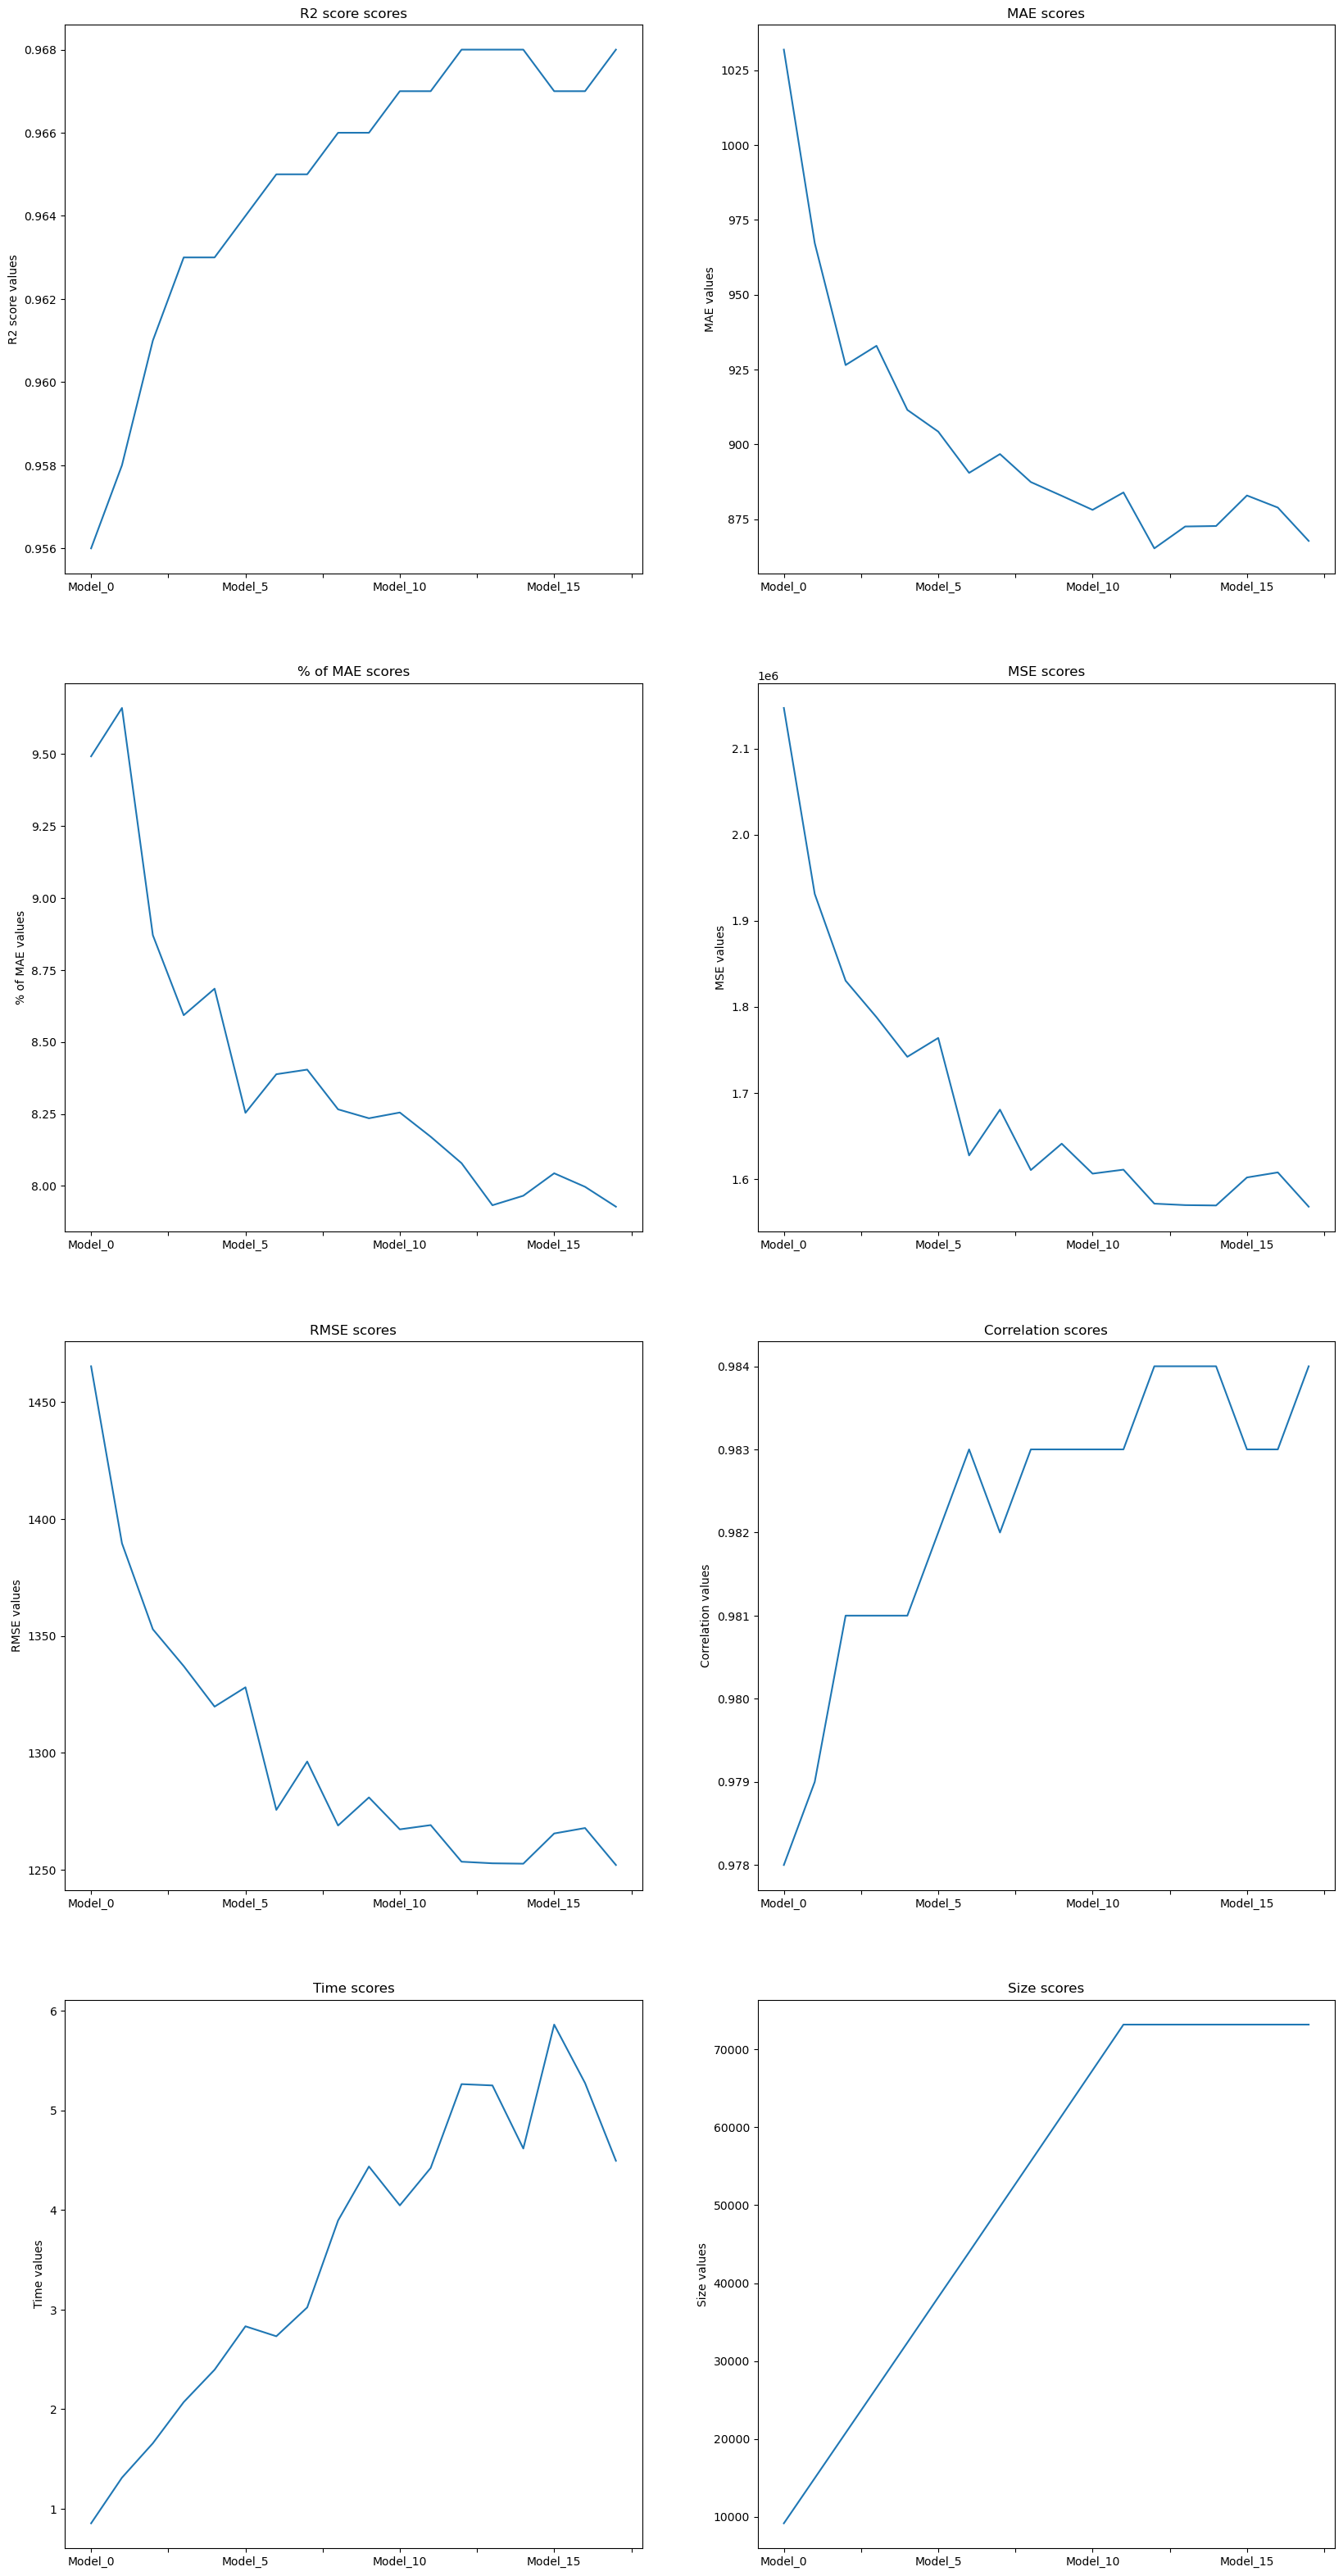

In [23]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp2.index):
    plt.subplot(4,2,i+1)
    df_scores_exp2.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [24]:
df_scores_exp2.to_excel('exp2_scores.xlsx')

## Experiment 3

This is the dynamic sliding window approach. Concatenating new data to existing dataset or sliding window to dispose old data points occur based on comparison of performance of models. 

If new data bring fresh information and improve performance then it is added otherwise the data window slides. 

In [25]:
data = pd.DataFrame()

process_dict = {}

# get consecutive data chunk in each iteration 
for grp in idx_grp.keys():
   
    if grp > 1: # run after second iteration

        
        if globals()[f'per_mae_{grp-1}'] > globals()[f'per_mae_{grp-2}']: # Compare model performance
            
            concat_data(grp) # concatenate data if final model weaker
            process_dict[grp] = 'Concatenation'
        
        else:
            
            slide(grp) # dispose old data points if final model is better
            process_dict[grp] = 'Sliding Window'
            
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
    else: # initiate first two models with concatenating data chunks
           
        concat_data(grp)
        process_dict[grp] = 'Concatenation'
        
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
        

In [26]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp3 = pd.concat([exp_res, a])

df_scores_exp3.rename(columns=cols, inplace=True)

In [27]:
df_scores_exp3

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Model_11,Model_12,Model_13,Model_14,Model_15,Model_16,Model_17
R2 score,9.560000e-01,9.580000e-01,9.610000e-01,9.640000e-01,9.610000e-01,9.640000e-01,9.620000e-01,9.650000e-01,9.620000e-01,9.640000e-01,9.650000e-01,9.650000e-01,9.640000e-01,9.650000e-01,9.670000e-01,9.640000e-01,9.660000e-01,9.670000e-01
MAE,1.031892e+03,9.672550e+02,9.264970e+02,9.378460e+02,9.543670e+02,9.260100e+02,9.419560e+02,9.317990e+02,9.186430e+02,9.159720e+02,9.076720e+02,8.891520e+02,9.080050e+02,9.037290e+02,8.940130e+02,9.214840e+02,8.928660e+02,8.938440e+02
% of MAE,9.492000e+00,9.660000e+00,8.871000e+00,8.639000e+00,8.733000e+00,8.657000e+00,8.604000e+00,8.376000e+00,8.448000e+00,8.339000e+00,8.357000e+00,8.165000e+00,8.273000e+00,8.228000e+00,8.207000e+00,8.242000e+00,8.090000e+00,8.075000e+00
MSE,2.147322e+06,1.931143e+06,1.830335e+06,1.863244e+06,1.900030e+06,1.771833e+06,1.861183e+06,1.756063e+06,1.814712e+06,1.770633e+06,1.752320e+06,1.685898e+06,1.745748e+06,1.699944e+06,1.631826e+06,1.792351e+06,1.656675e+06,1.639821e+06
RMSE,1.465374e+03,1.389656e+03,1.352899e+03,1.365007e+03,1.378416e+03,1.331102e+03,1.364252e+03,1.325165e+03,1.347113e+03,1.330651e+03,1.323752e+03,1.298421e+03,1.321267e+03,1.303819e+03,1.277429e+03,1.338787e+03,1.287119e+03,1.280555e+03
Correlation,9.780000e-01,9.790000e-01,9.810000e-01,9.820000e-01,9.800000e-01,9.820000e-01,9.810000e-01,9.820000e-01,9.810000e-01,9.820000e-01,9.820000e-01,9.820000e-01,9.820000e-01,9.830000e-01,9.840000e-01,9.820000e-01,9.830000e-01,9.830000e-01
Time,8.949218e-01,1.388006e+00,1.442602e+00,1.320309e+00,1.310209e+00,1.606578e+00,1.587556e+00,1.607649e+00,1.959079e+00,2.401426e+00,2.377440e+00,2.545068e+00,2.331442e+00,2.655724e+00,3.214849e+00,3.578135e+00,3.301185e+00,3.017318e+00
Size,9.165000e+03,1.495900e+04,2.075800e+04,2.075800e+04,2.075800e+04,2.658000e+04,2.658000e+04,2.658000e+04,2.658000e+04,3.241800e+04,3.241800e+04,3.827300e+04,3.827300e+04,4.415000e+04,4.415000e+04,4.415000e+04,5.010400e+04,5.010400e+04


<function matplotlib.pyplot.show(close=None, block=None)>

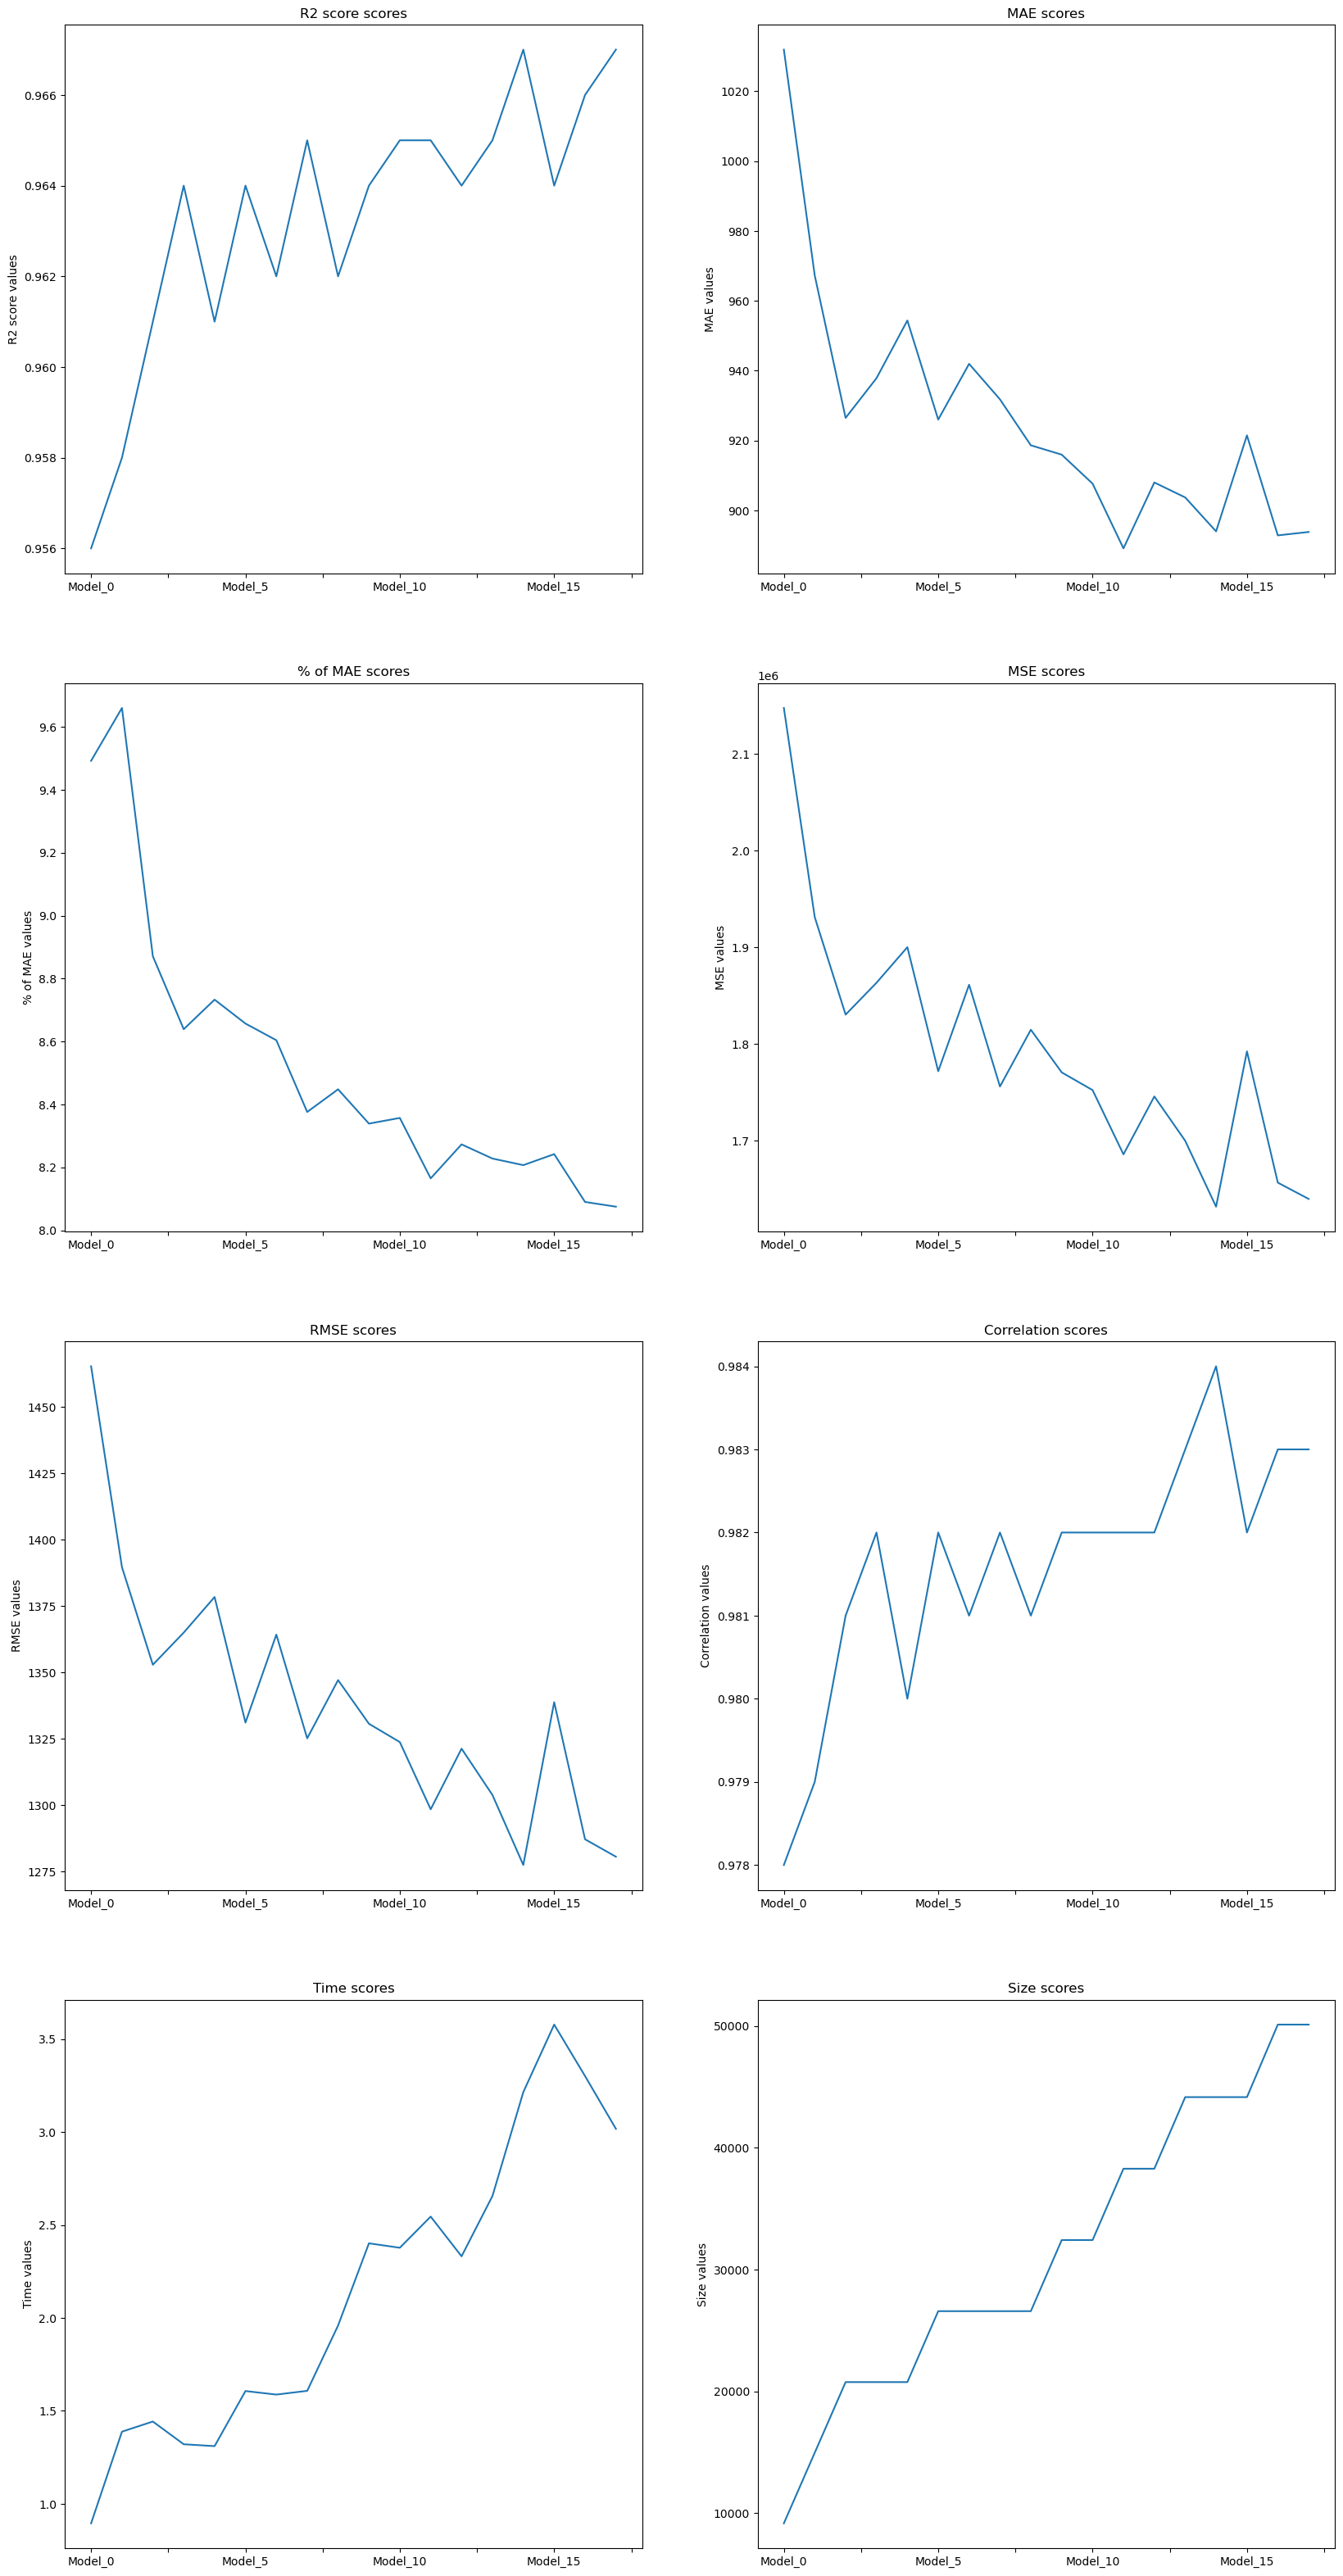

In [28]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp3.index):
    plt.subplot(4,2,i+1)
    df_scores_exp3.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [29]:
len(data)

50104

In [30]:
process_dict

{0: 'Concatenation',
 1: 'Concatenation',
 2: 'Concatenation',
 3: 'Sliding Window',
 4: 'Sliding Window',
 5: 'Concatenation',
 6: 'Sliding Window',
 7: 'Sliding Window',
 8: 'Sliding Window',
 9: 'Concatenation',
 10: 'Sliding Window',
 11: 'Concatenation',
 12: 'Sliding Window',
 13: 'Concatenation',
 14: 'Sliding Window',
 15: 'Sliding Window',
 16: 'Concatenation',
 17: 'Sliding Window'}

In [31]:
df_scores_exp3.to_excel('exp3_scores.xlsx')

### Experiment 4

30 chunks

In [33]:
df_ = df[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

idx_grp = data_stratification(df_, 'Group', 30)

In [34]:
data = pd.DataFrame()

process_dict = {}

# get consecutive data chunk in each iteration 
for grp in idx_grp.keys():
   
    if grp > 1: # run after second iteration

        
        if globals()[f'per_mae_{grp-1}'] > globals()[f'per_mae_{grp-2}']: # Compare model performance
            
            concat_data(grp) # concatenate data if final model weaker
            process_dict[grp] = 'Concatenation'
        
        else:
            
            slide(grp) # dispose old data points if final model is better
            process_dict[grp] = 'Sliding Window'
            
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
    else: # initiate first two models with concatenating data chunks
           
        concat_data(grp)
        process_dict[grp] = 'Concatenation'
        
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
               

In [35]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp4 = pd.concat([exp_res, a])

df_scores_exp4.rename(columns=cols, inplace=True)

In [36]:
df_scores_exp4

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,...,Model_20,Model_21,Model_22,Model_23,Model_24,Model_25,Model_26,Model_27,Model_28,Model_29
R2 score,9.530000e-01,9.580000e-01,9.500000e-01,9.490000e-01,9.570000e-01,9.570000e-01,9.610000e-01,9.610000e-01,9.630000e-01,9.610000e-01,...,9.660000e-01,9.650000e-01,9.650000e-01,9.640000e-01,9.650000e-01,9.660000e-01,9.640000e-01,9.660000e-01,9.670000e-01,9.660000e-01
MAE,1.058805e+03,1.010779e+03,1.028409e+03,1.058143e+03,1.021392e+03,1.003740e+03,9.768610e+02,9.590880e+02,9.283330e+02,9.412460e+02,...,9.086980e+02,9.155010e+02,9.205110e+02,9.170410e+02,9.049300e+02,8.970900e+02,9.259130e+02,9.067980e+02,9.042930e+02,8.917890e+02
% of MAE,9.827000e+00,9.622000e+00,9.544000e+00,9.387000e+00,9.457000e+00,8.807000e+00,8.939000e+00,8.833000e+00,8.710000e+00,8.535000e+00,...,8.359000e+00,8.184000e+00,8.265000e+00,8.260000e+00,8.205000e+00,8.161000e+00,8.185000e+00,8.188000e+00,8.220000e+00,8.071000e+00
MSE,2.443704e+06,2.163488e+06,2.616192e+06,2.756254e+06,2.213733e+06,2.146259e+06,1.960671e+06,1.923028e+06,1.760733e+06,1.808463e+06,...,1.659904e+06,1.733272e+06,1.729973e+06,1.732691e+06,1.688812e+06,1.648027e+06,1.798964e+06,1.707663e+06,1.646955e+06,1.663460e+06
RMSE,1.563235e+03,1.470880e+03,1.617465e+03,1.660197e+03,1.487862e+03,1.465012e+03,1.400240e+03,1.386733e+03,1.326926e+03,1.344791e+03,...,1.288373e+03,1.316538e+03,1.315285e+03,1.316317e+03,1.299543e+03,1.283755e+03,1.341254e+03,1.306776e+03,1.283337e+03,1.289752e+03
Correlation,9.760000e-01,9.790000e-01,9.750000e-01,9.740000e-01,9.780000e-01,9.780000e-01,9.800000e-01,9.800000e-01,9.820000e-01,9.800000e-01,...,9.830000e-01,9.820000e-01,9.820000e-01,9.820000e-01,9.830000e-01,9.830000e-01,9.820000e-01,9.830000e-01,9.830000e-01,9.830000e-01
Time,4.559009e-01,6.597490e-01,6.939714e-01,7.234628e-01,6.927676e-01,8.740933e-01,9.596572e-01,1.351219e+00,1.343468e+00,1.350392e+00,...,1.987884e+00,2.211209e+00,2.110084e+00,2.538387e+00,2.876221e+00,2.822520e+00,2.483836e+00,2.636749e+00,2.790296e+00,3.699917e+00
Size,5.680000e+03,9.168000e+03,9.168000e+03,9.168000e+03,9.168000e+03,1.265400e+04,1.265400e+04,1.615600e+04,1.615600e+04,1.615600e+04,...,3.031800e+04,3.390300e+04,3.390300e+04,3.748400e+04,3.748400e+04,3.748400e+04,3.748400e+04,4.113800e+04,4.481200e+04,4.847100e+04


<function matplotlib.pyplot.show(close=None, block=None)>

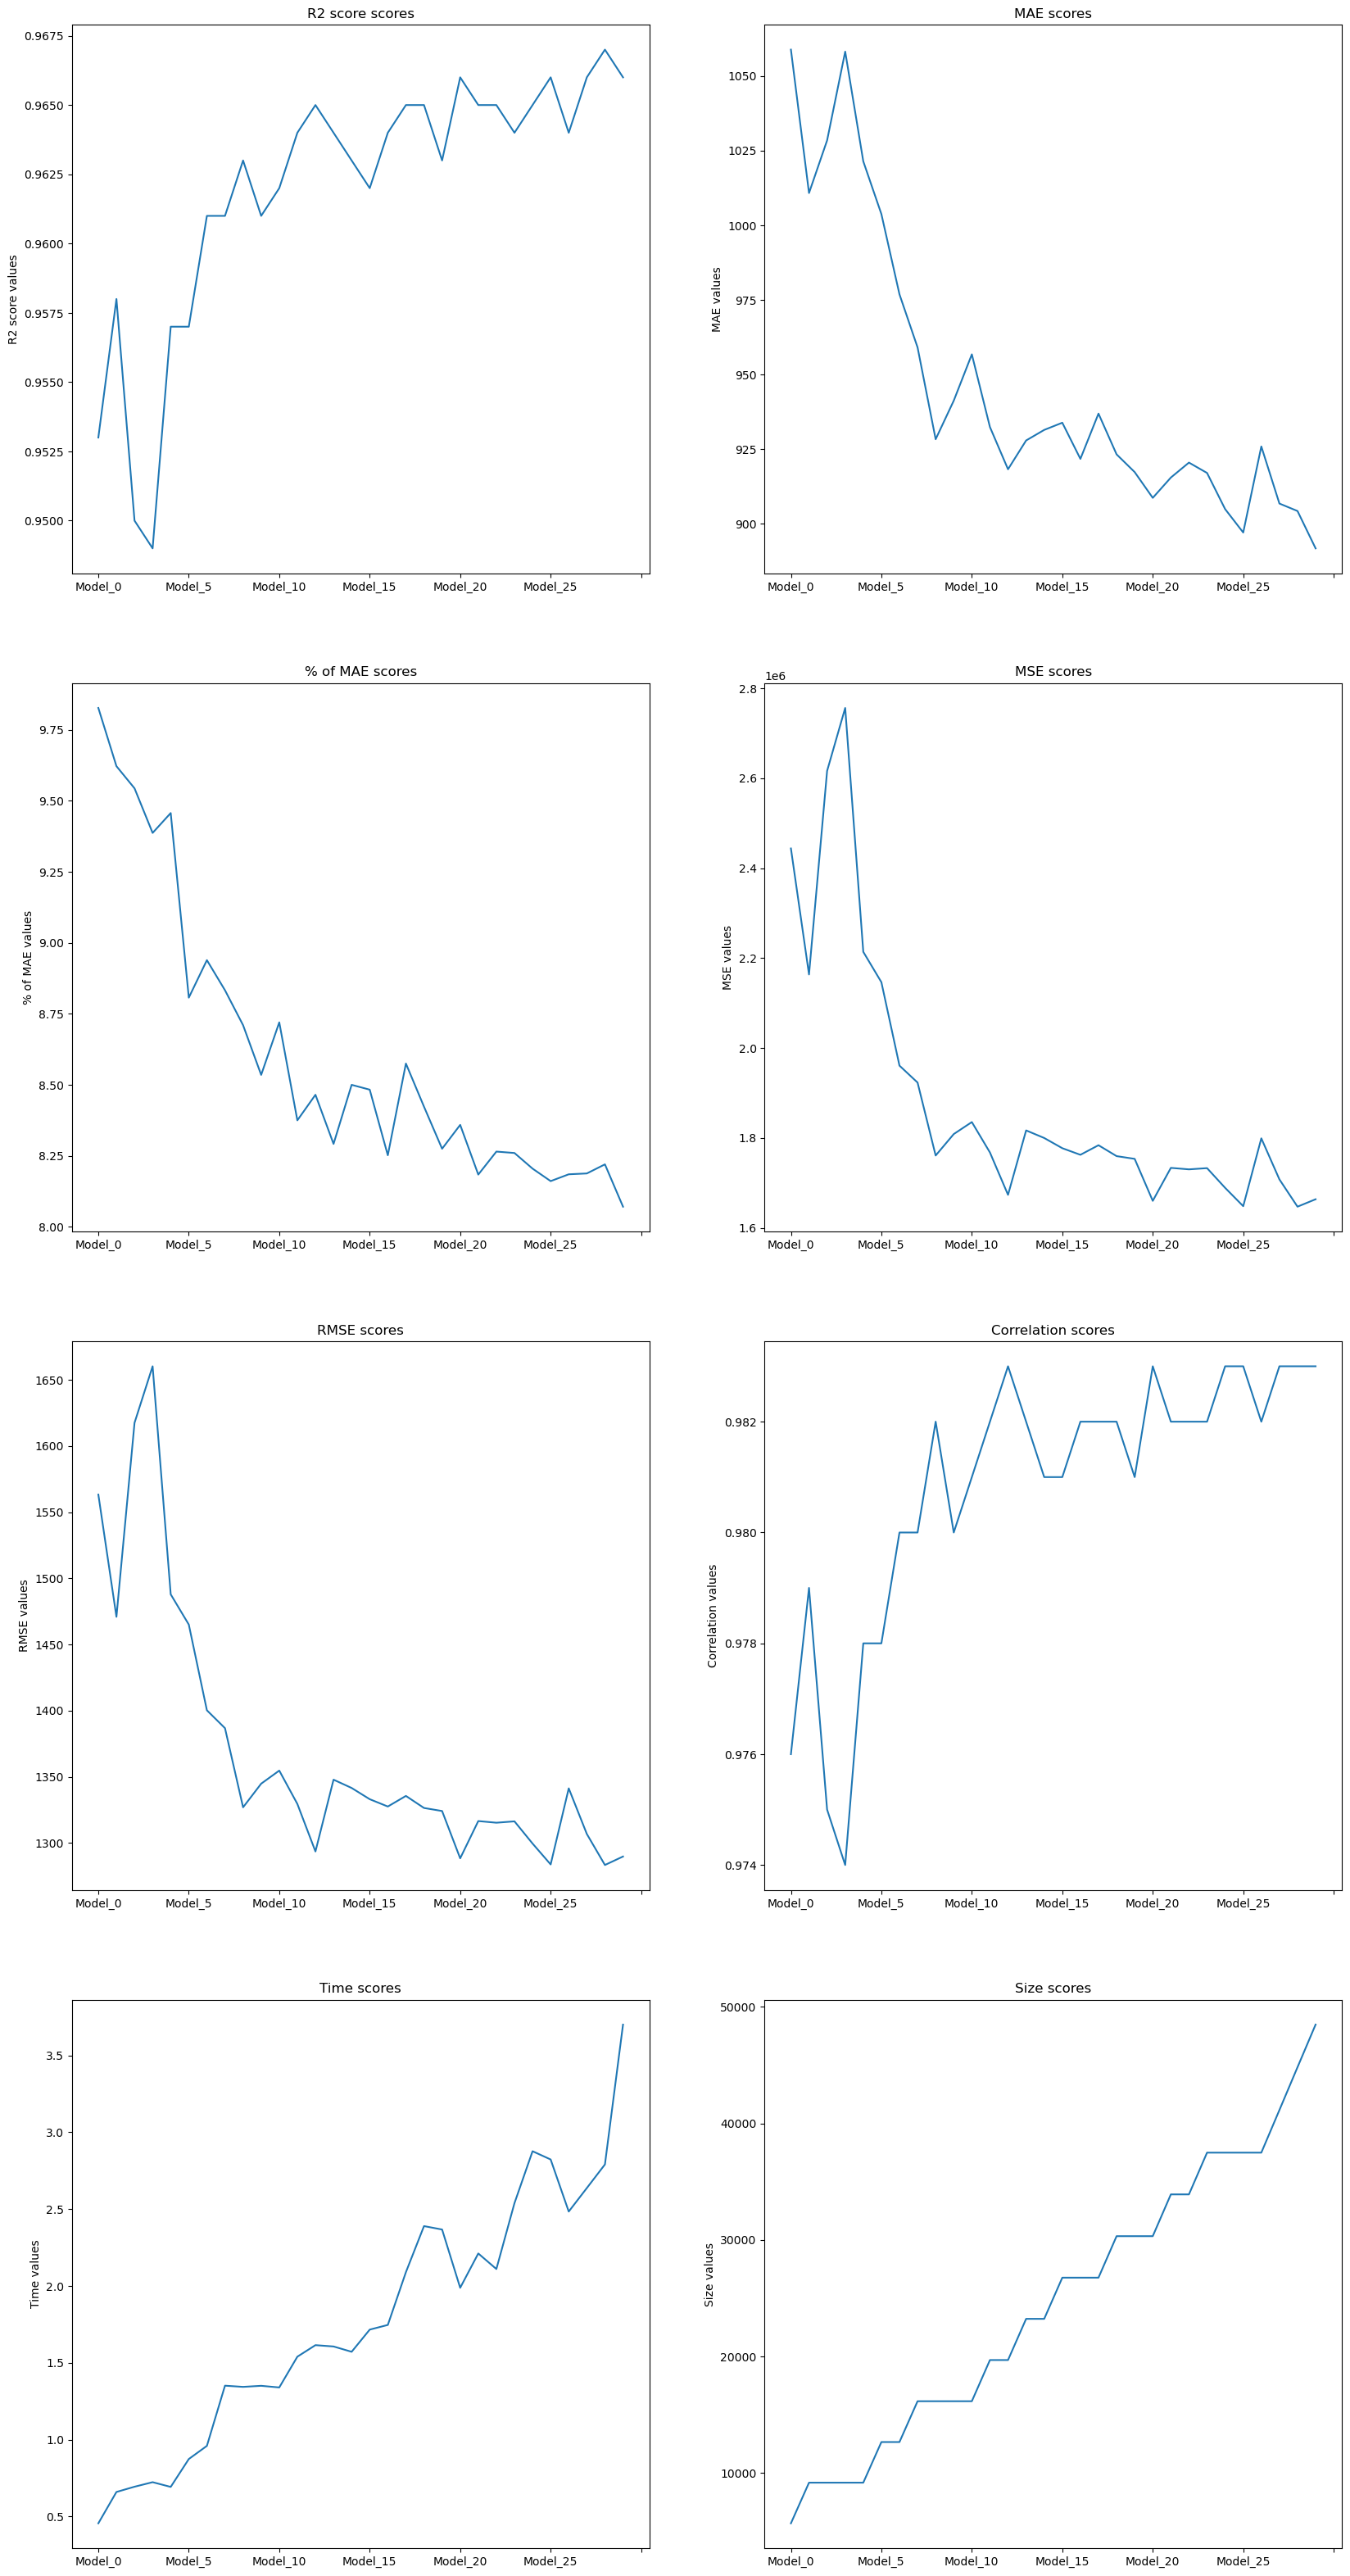

In [37]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp4.index):
    plt.subplot(4,2,i+1)
    df_scores_exp4.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [38]:
df_scores_exp4.to_excel('exp4_scores.xlsx')

### Experiment 5

40 chunks

In [40]:
df_ = df[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

idx_grp = data_stratification(df_, 'Group', 40)

In [41]:
data = pd.DataFrame()

process_dict = {}

# get consecutive data chunk in each iteration 
for grp in idx_grp.keys():
   
    if grp > 1: # run after second iteration

        
        if globals()[f'per_mae_{grp-1}'] > globals()[f'per_mae_{grp-2}']: # Compare model performance
            
            concat_data(grp) # concatenate data if final model weaker
            process_dict[grp] = 'Concatenation'
        
        else:
            
            slide(grp) # dispose old data points if final model is better
            process_dict[grp] = 'Sliding Window'
            
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
    else: # initiate first two models with concatenating data chunks
           
        concat_data(grp)
        process_dict[grp] = 'Concatenation'
        
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
        

In [42]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp5 = pd.concat([exp_res, a])

df_scores_exp5.rename(columns=cols, inplace=True)

In [43]:
df_scores_exp5

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,...,Model_30,Model_31,Model_32,Model_33,Model_34,Model_35,Model_36,Model_37,Model_38,Model_39
R2 score,9.430000e-01,9.530000e-01,9.530000e-01,9.570000e-01,9.610000e-01,9.540000e-01,9.530000e-01,9.600000e-01,9.580000e-01,9.580000e-01,...,9.640000e-01,9.650000e-01,9.640000e-01,9.660000e-01,9.670000e-01,9.660000e-01,9.660000e-01,9.660000e-01,9.680000e-01,9.670000e-01
MAE,1.122128e+03,1.066615e+03,1.046842e+03,1.037372e+03,9.690830e+02,1.020232e+03,1.015559e+03,9.694580e+02,9.646890e+02,9.840210e+02,...,9.149540e+02,9.172210e+02,9.294790e+02,8.915380e+02,8.901950e+02,9.042340e+02,9.087780e+02,8.906720e+02,8.790740e+02,8.947230e+02
% of MAE,9.902000e+00,1.007800e+01,9.783000e+00,1.005400e+01,9.492000e+00,9.545000e+00,9.127000e+00,8.837000e+00,8.760000e+00,8.964000e+00,...,8.391000e+00,8.243000e+00,8.259000e+00,8.094000e+00,8.076000e+00,8.221000e+00,8.158000e+00,8.142000e+00,7.929000e+00,8.205000e+00
MSE,2.791621e+06,2.263130e+06,2.296951e+06,2.152494e+06,1.951575e+06,2.312853e+06,2.349919e+06,1.951603e+06,2.084761e+06,2.093479e+06,...,1.726114e+06,1.730382e+06,1.747605e+06,1.618196e+06,1.589519e+06,1.638758e+06,1.680520e+06,1.651888e+06,1.560565e+06,1.649196e+06
RMSE,1.670814e+03,1.504370e+03,1.515569e+03,1.467138e+03,1.396988e+03,1.520807e+03,1.532945e+03,1.396998e+03,1.443870e+03,1.446886e+03,...,1.313817e+03,1.315440e+03,1.321970e+03,1.272083e+03,1.260761e+03,1.280140e+03,1.296349e+03,1.285258e+03,1.249226e+03,1.284210e+03
Correlation,9.710000e-01,9.760000e-01,9.760000e-01,9.780000e-01,9.800000e-01,9.770000e-01,9.760000e-01,9.800000e-01,9.790000e-01,9.790000e-01,...,9.820000e-01,9.820000e-01,9.820000e-01,9.830000e-01,9.840000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.840000e-01,9.830000e-01
Time,3.840091e-01,5.561633e-01,7.817516e-01,7.992971e-01,9.431648e-01,9.574761e-01,1.226559e+00,1.368166e+00,1.366546e+00,1.369298e+00,...,3.311366e+00,3.843572e+00,2.915998e+00,3.558949e+00,3.588749e+00,3.511102e+00,3.157731e+00,3.060004e+00,3.596683e+00,3.621289e+00
Size,4.330000e+03,6.953000e+03,9.577000e+03,9.577000e+03,1.220300e+04,1.220300e+04,1.482700e+04,1.482700e+04,1.482700e+04,1.482700e+04,...,3.343700e+04,3.615000e+04,3.615000e+04,3.889500e+04,3.889500e+04,3.889500e+04,4.164900e+04,4.164900e+04,4.164900e+04,4.164900e+04


<function matplotlib.pyplot.show(close=None, block=None)>

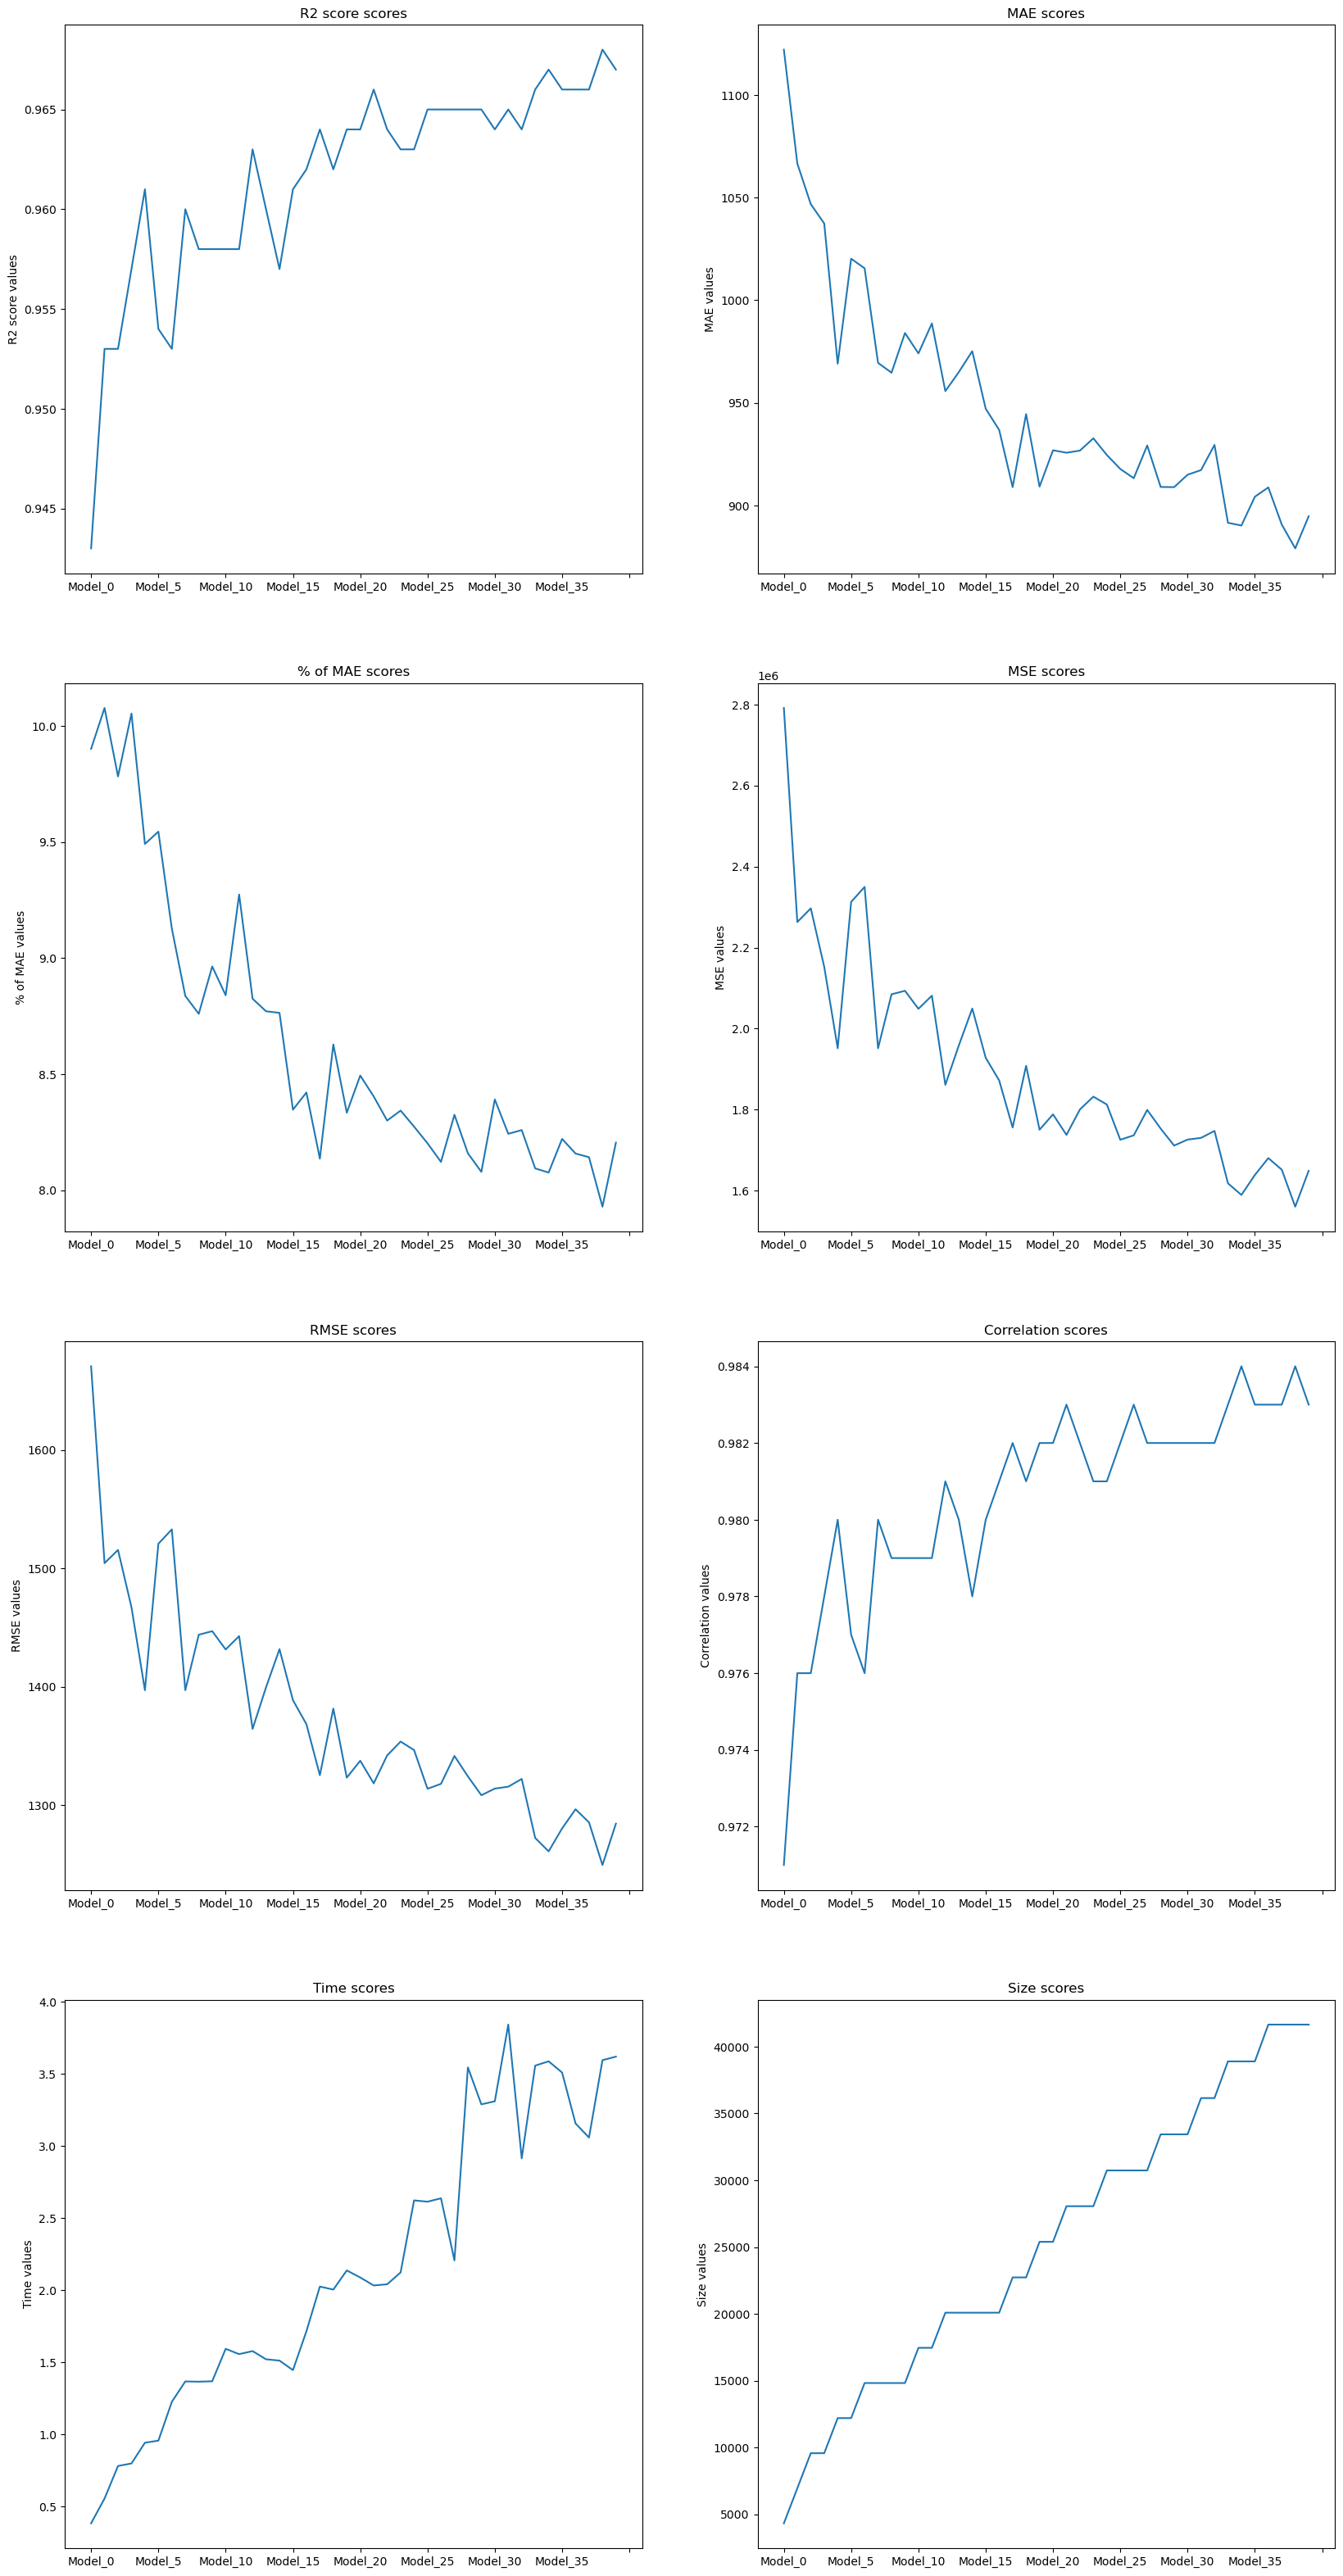

In [44]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp5.index):
    plt.subplot(4,2,i+1)
    df_scores_exp5.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [45]:
df_scores_exp5.to_excel('exp5_scores.xlsx')

### Experiment 6

50 chunks

In [47]:
df_ = df[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

idx_grp = data_stratification(df_, 'Group', 50)

In [48]:
data = pd.DataFrame()

process_dict = {}

# get consecutive data chunk in each iteration 
for grp in idx_grp.keys():
   
    if grp > 1: # run after second iteration

        
        if globals()[f'per_mae_{grp-1}'] > globals()[f'per_mae_{grp-2}']: # Compare model performance
            
            concat_data(grp) # concatenate data if final model weaker
            process_dict[grp] = 'Concatenation'
        
        else:
            
            slide(grp) # dispose old data points if final model is better
            process_dict[grp] = 'Sliding Window'
            
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
    else: # initiate first two models with concatenating data chunks
           
        concat_data(grp)
        process_dict[grp] = 'Concatenation'
        
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
        

In [49]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp6 = pd.concat([exp_res, a])

df_scores_exp6.rename(columns=cols, inplace=True)

In [50]:
df_scores_exp6

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,...,Model_40,Model_41,Model_42,Model_43,Model_44,Model_45,Model_46,Model_47,Model_48,Model_49
R2 score,9.460000e-01,9.450000e-01,9.370000e-01,9.500000e-01,9.540000e-01,9.550000e-01,9.570000e-01,9.560000e-01,9.550000e-01,9.560000e-01,...,9.640000e-01,9.650000e-01,9.660000e-01,9.650000e-01,9.640000e-01,9.640000e-01,9.670000e-01,9.660000e-01,9.670000e-01,9.670000e-01
MAE,1.150133e+03,1.153079e+03,1.174351e+03,1.093964e+03,1.028090e+03,1.047579e+03,1.006908e+03,1.010954e+03,1.028286e+03,9.830720e+02,...,8.941740e+02,9.109890e+02,8.913530e+02,8.956860e+02,9.003920e+02,8.979400e+02,8.768980e+02,8.881150e+02,8.781620e+02,8.904920e+02
% of MAE,1.106500e+01,1.073800e+01,1.112100e+01,1.204500e+01,1.058800e+01,9.806000e+00,9.726000e+00,9.280000e+00,9.469000e+00,8.874000e+00,...,8.064000e+00,8.176000e+00,7.933000e+00,8.181000e+00,8.145000e+00,8.161000e+00,7.957000e+00,8.104000e+00,8.009000e+00,8.092000e+00
MSE,2.647317e+06,2.789732e+06,3.395573e+06,2.561355e+06,2.279419e+06,2.274573e+06,2.054075e+06,2.189691e+06,2.253968e+06,2.205814e+06,...,1.709680e+06,1.721468e+06,1.647800e+06,1.687352e+06,1.696208e+06,1.678606e+06,1.549567e+06,1.620217e+06,1.574342e+06,1.623262e+06
RMSE,1.627058e+03,1.670249e+03,1.842708e+03,1.600423e+03,1.509774e+03,1.508169e+03,1.433204e+03,1.479760e+03,1.501322e+03,1.485198e+03,...,1.307547e+03,1.312047e+03,1.283667e+03,1.298981e+03,1.302385e+03,1.295610e+03,1.244816e+03,1.272878e+03,1.254728e+03,1.274073e+03
Correlation,9.730000e-01,9.720000e-01,9.680000e-01,9.750000e-01,9.770000e-01,9.780000e-01,9.780000e-01,9.780000e-01,9.770000e-01,9.780000e-01,...,9.820000e-01,9.820000e-01,9.830000e-01,9.820000e-01,9.820000e-01,9.820000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.830000e-01
Time,3.281410e-01,5.229414e-01,6.118851e-01,8.085325e-01,9.766321e-01,9.789839e-01,9.730430e-01,9.692514e-01,9.736226e-01,1.105017e+00,...,2.905622e+00,3.456395e+00,3.680547e+00,3.361636e+00,3.251272e+00,3.561088e+00,4.090077e+00,3.730535e+00,3.711930e+00,3.855103e+00
Size,3.479000e+03,5.572000e+03,5.572000e+03,7.665000e+03,9.751000e+03,9.751000e+03,9.751000e+03,9.751000e+03,9.751000e+03,1.185300e+04,...,4.178100e+04,4.178100e+04,4.397500e+04,4.397500e+04,4.619600e+04,4.619600e+04,4.841300e+04,4.841300e+04,5.065500e+04,5.065500e+04


<function matplotlib.pyplot.show(close=None, block=None)>

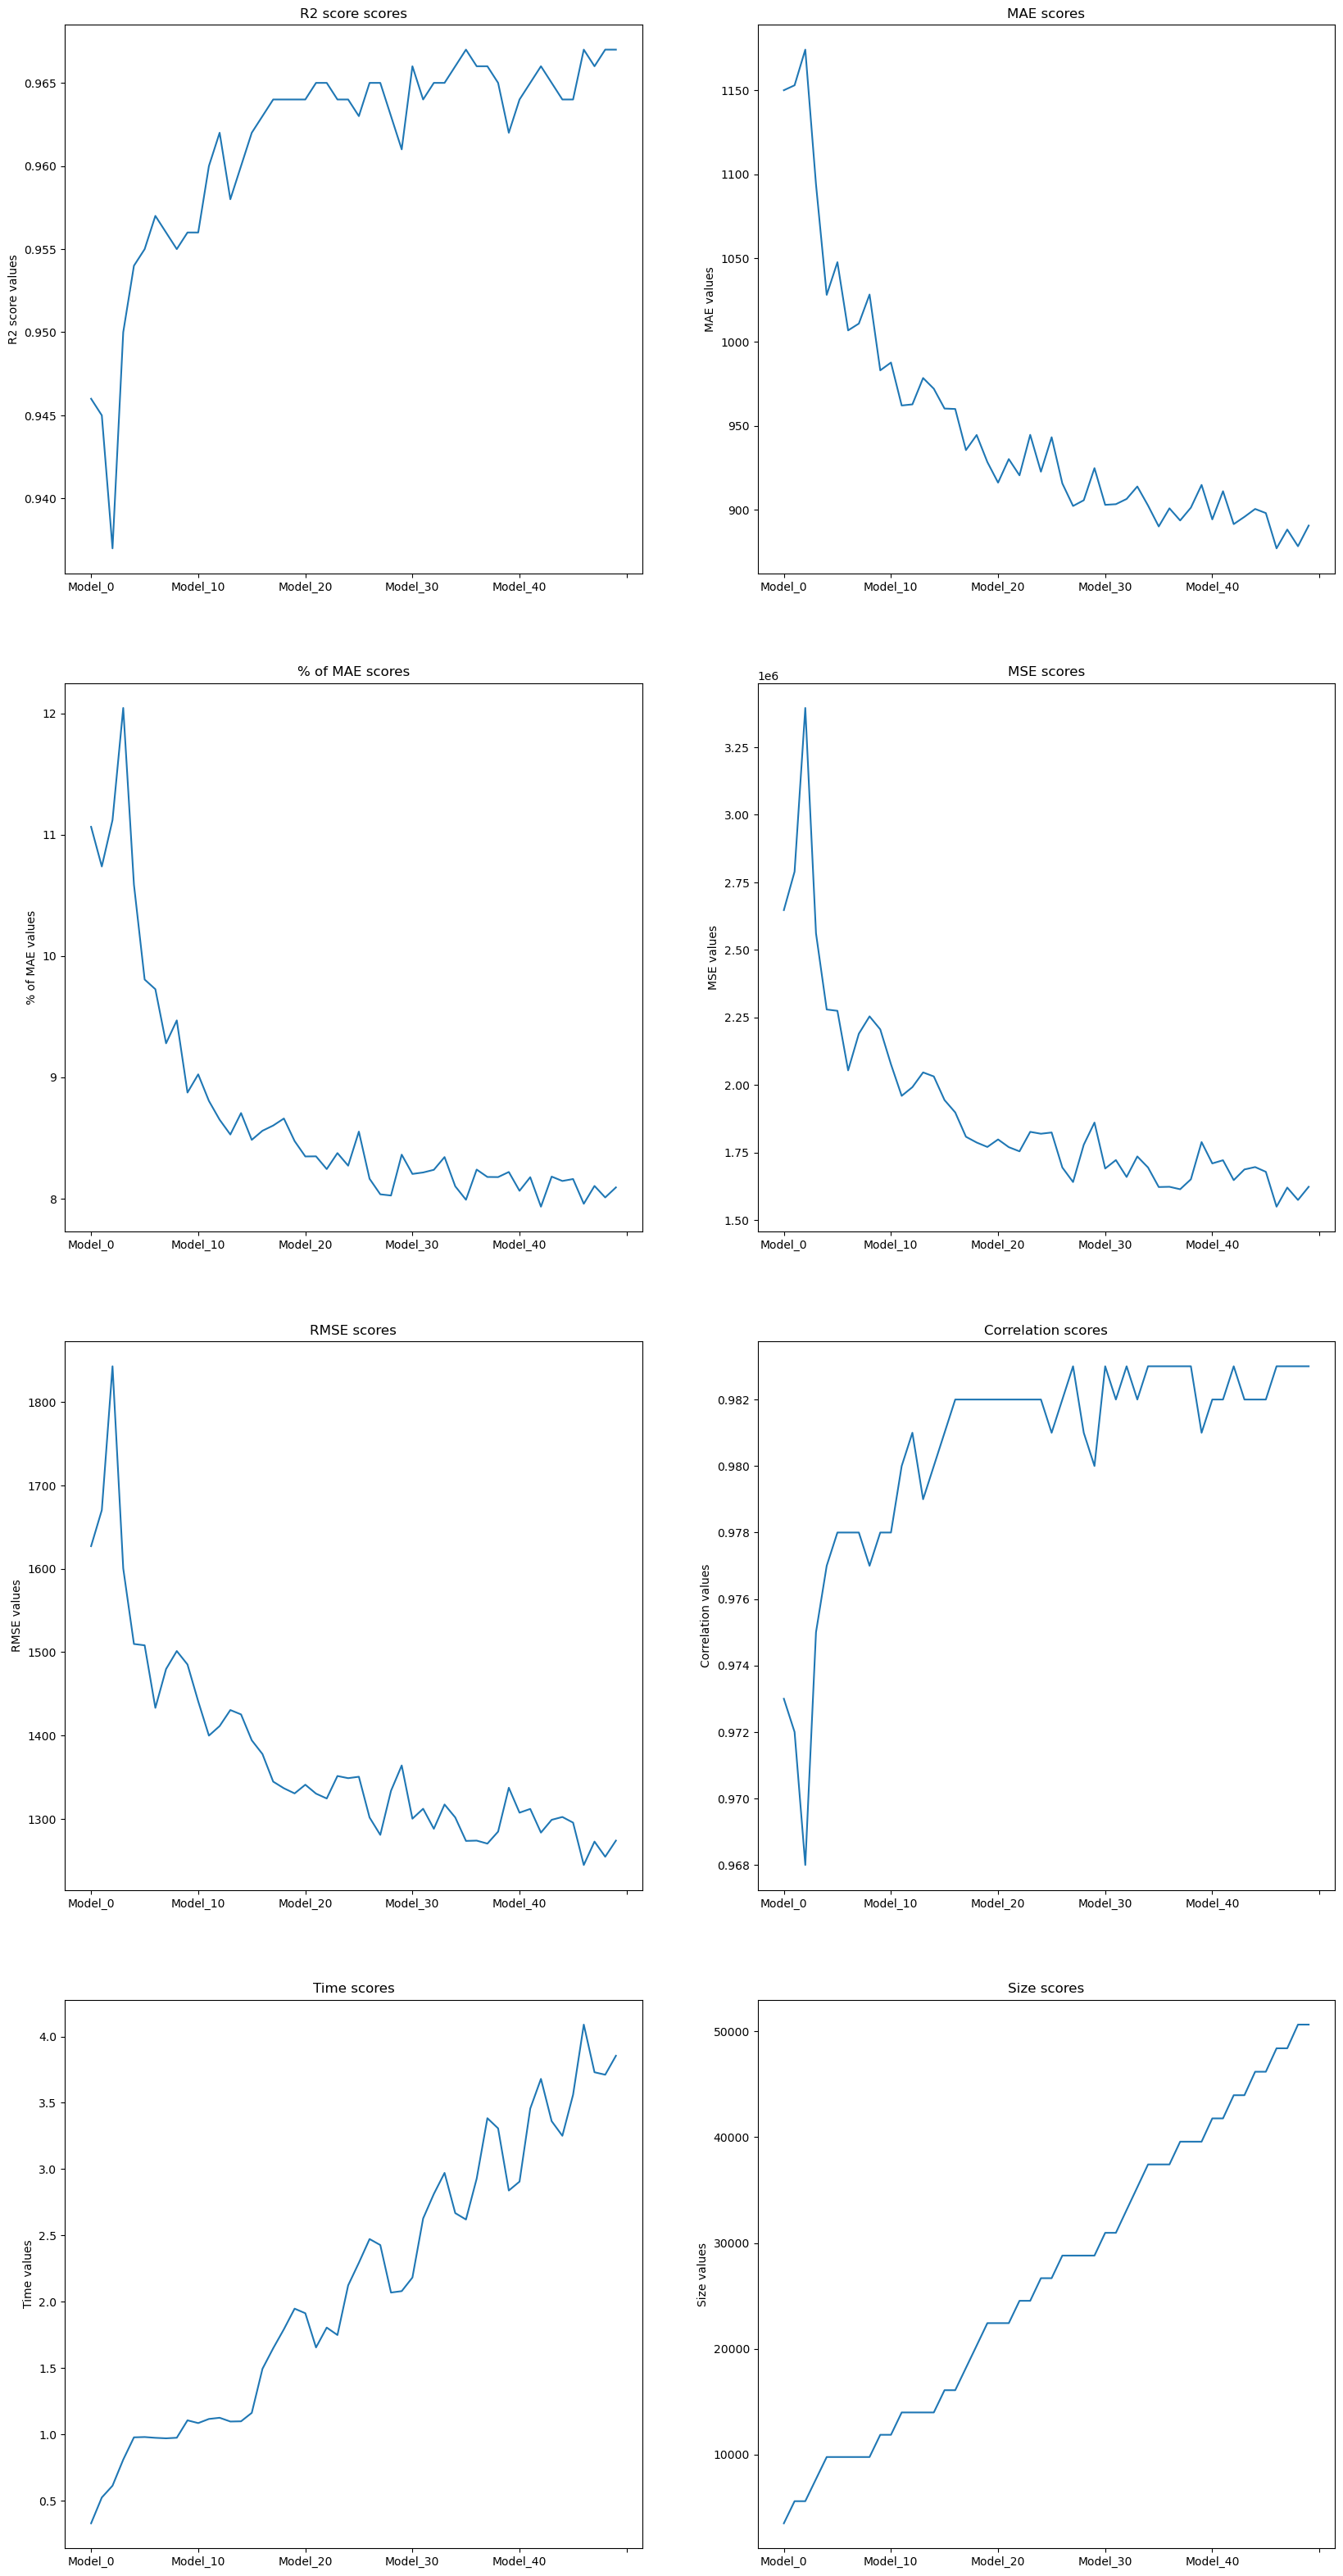

In [51]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp6.index):
    plt.subplot(4,2,i+1)
    df_scores_exp6.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [52]:
len(data)

50655

In [53]:
df_scores_exp6.to_excel('exp6_scores.xlsx')

### Experiment 7

100 chunks

In [55]:
df_ = df[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

idx_grp = data_stratification(df_, 'Group', 100)

In [56]:
data = pd.DataFrame()

process_dict = {}

# get consecutive data chunk in each iteration 
for grp in idx_grp.keys():
   
    if grp > 1: # run after second iteration

        
        if globals()[f'per_mae_{grp-1}'] > globals()[f'per_mae_{grp-2}']: # Compare model performance
            
            concat_data(grp) # concatenate data if final model weaker
            process_dict[grp] = 'Concatenation'
        
        else:
            
            slide(grp) # dispose old data points if final model is better
            process_dict[grp] = 'Sliding Window'
            
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
    else: # initiate first two models with concatenating data chunks
           
        concat_data(grp)
        process_dict[grp] = 'Concatenation'
        
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
        

In [57]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp7 = pd.concat([exp_res, a])

df_scores_exp7.rename(columns=cols, inplace=True)

In [58]:
df_scores_exp7

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,...,Model_90,Model_91,Model_92,Model_93,Model_94,Model_95,Model_96,Model_97,Model_98,Model_99
R2 score,9.340000e-01,9.470000e-01,9.420000e-01,9.410000e-01,9.430000e-01,9.450000e-01,9.560000e-01,9.610000e-01,9.590000e-01,9.620000e-01,...,9.660000e-01,9.640000e-01,9.650000e-01,9.660000e-01,9.630000e-01,9.640000e-01,9.650000e-01,9.640000e-01,9.650000e-01,9.620000e-01
MAE,1.226730e+03,1.157205e+03,1.152382e+03,1.083096e+03,1.084893e+03,1.073880e+03,1.047702e+03,1.021992e+03,1.020636e+03,1.008450e+03,...,8.903820e+02,9.065960e+02,8.943020e+02,8.868400e+02,9.112500e+02,8.997520e+02,8.923330e+02,8.970140e+02,8.963930e+02,9.137630e+02
% of MAE,1.055600e+01,1.159800e+01,1.161700e+01,1.040300e+01,1.104100e+01,1.022000e+01,1.039100e+01,1.010800e+01,1.035300e+01,1.044000e+01,...,7.790000e+00,7.950000e+00,7.851000e+00,7.721000e+00,7.964000e+00,7.804000e+00,7.840000e+00,7.952000e+00,7.938000e+00,7.958000e+00
MSE,3.188155e+06,2.631431e+06,2.857128e+06,3.042140e+06,2.979330e+06,2.955110e+06,2.267969e+06,2.109351e+06,2.185174e+06,2.088873e+06,...,1.629254e+06,1.738776e+06,1.714202e+06,1.627344e+06,1.768083e+06,1.747940e+06,1.668391e+06,1.689685e+06,1.678916e+06,1.751878e+06
RMSE,1.785541e+03,1.622169e+03,1.690304e+03,1.744173e+03,1.726073e+03,1.719043e+03,1.505978e+03,1.452360e+03,1.478234e+03,1.445293e+03,...,1.276422e+03,1.318627e+03,1.309276e+03,1.275674e+03,1.329693e+03,1.322097e+03,1.291662e+03,1.299879e+03,1.295730e+03,1.323585e+03
Correlation,9.670000e-01,9.730000e-01,9.710000e-01,9.700000e-01,9.710000e-01,9.720000e-01,9.780000e-01,9.800000e-01,9.790000e-01,9.810000e-01,...,9.830000e-01,9.820000e-01,9.820000e-01,9.830000e-01,9.810000e-01,9.820000e-01,9.820000e-01,9.820000e-01,9.820000e-01,9.810000e-01
Time,2.441792e-01,2.982183e-01,3.891308e-01,5.876143e-01,5.085781e-01,5.732250e-01,7.080438e-01,8.035340e-01,7.230430e-01,8.023865e-01,...,3.144702e+00,3.826295e+00,3.913445e+00,3.370380e+00,3.285576e+00,4.026816e+00,3.948664e+00,3.610578e+00,3.467890e+00,4.173161e+00
Size,1.790000e+03,2.873000e+03,3.957000e+03,5.036000e+03,5.036000e+03,6.107000e+03,6.107000e+03,7.176000e+03,7.176000e+03,8.249000e+03,...,4.591500e+04,4.591500e+04,4.702400e+04,4.702400e+04,4.702400e+04,4.813900e+04,4.813900e+04,4.928600e+04,5.042700e+04,5.042700e+04


<function matplotlib.pyplot.show(close=None, block=None)>

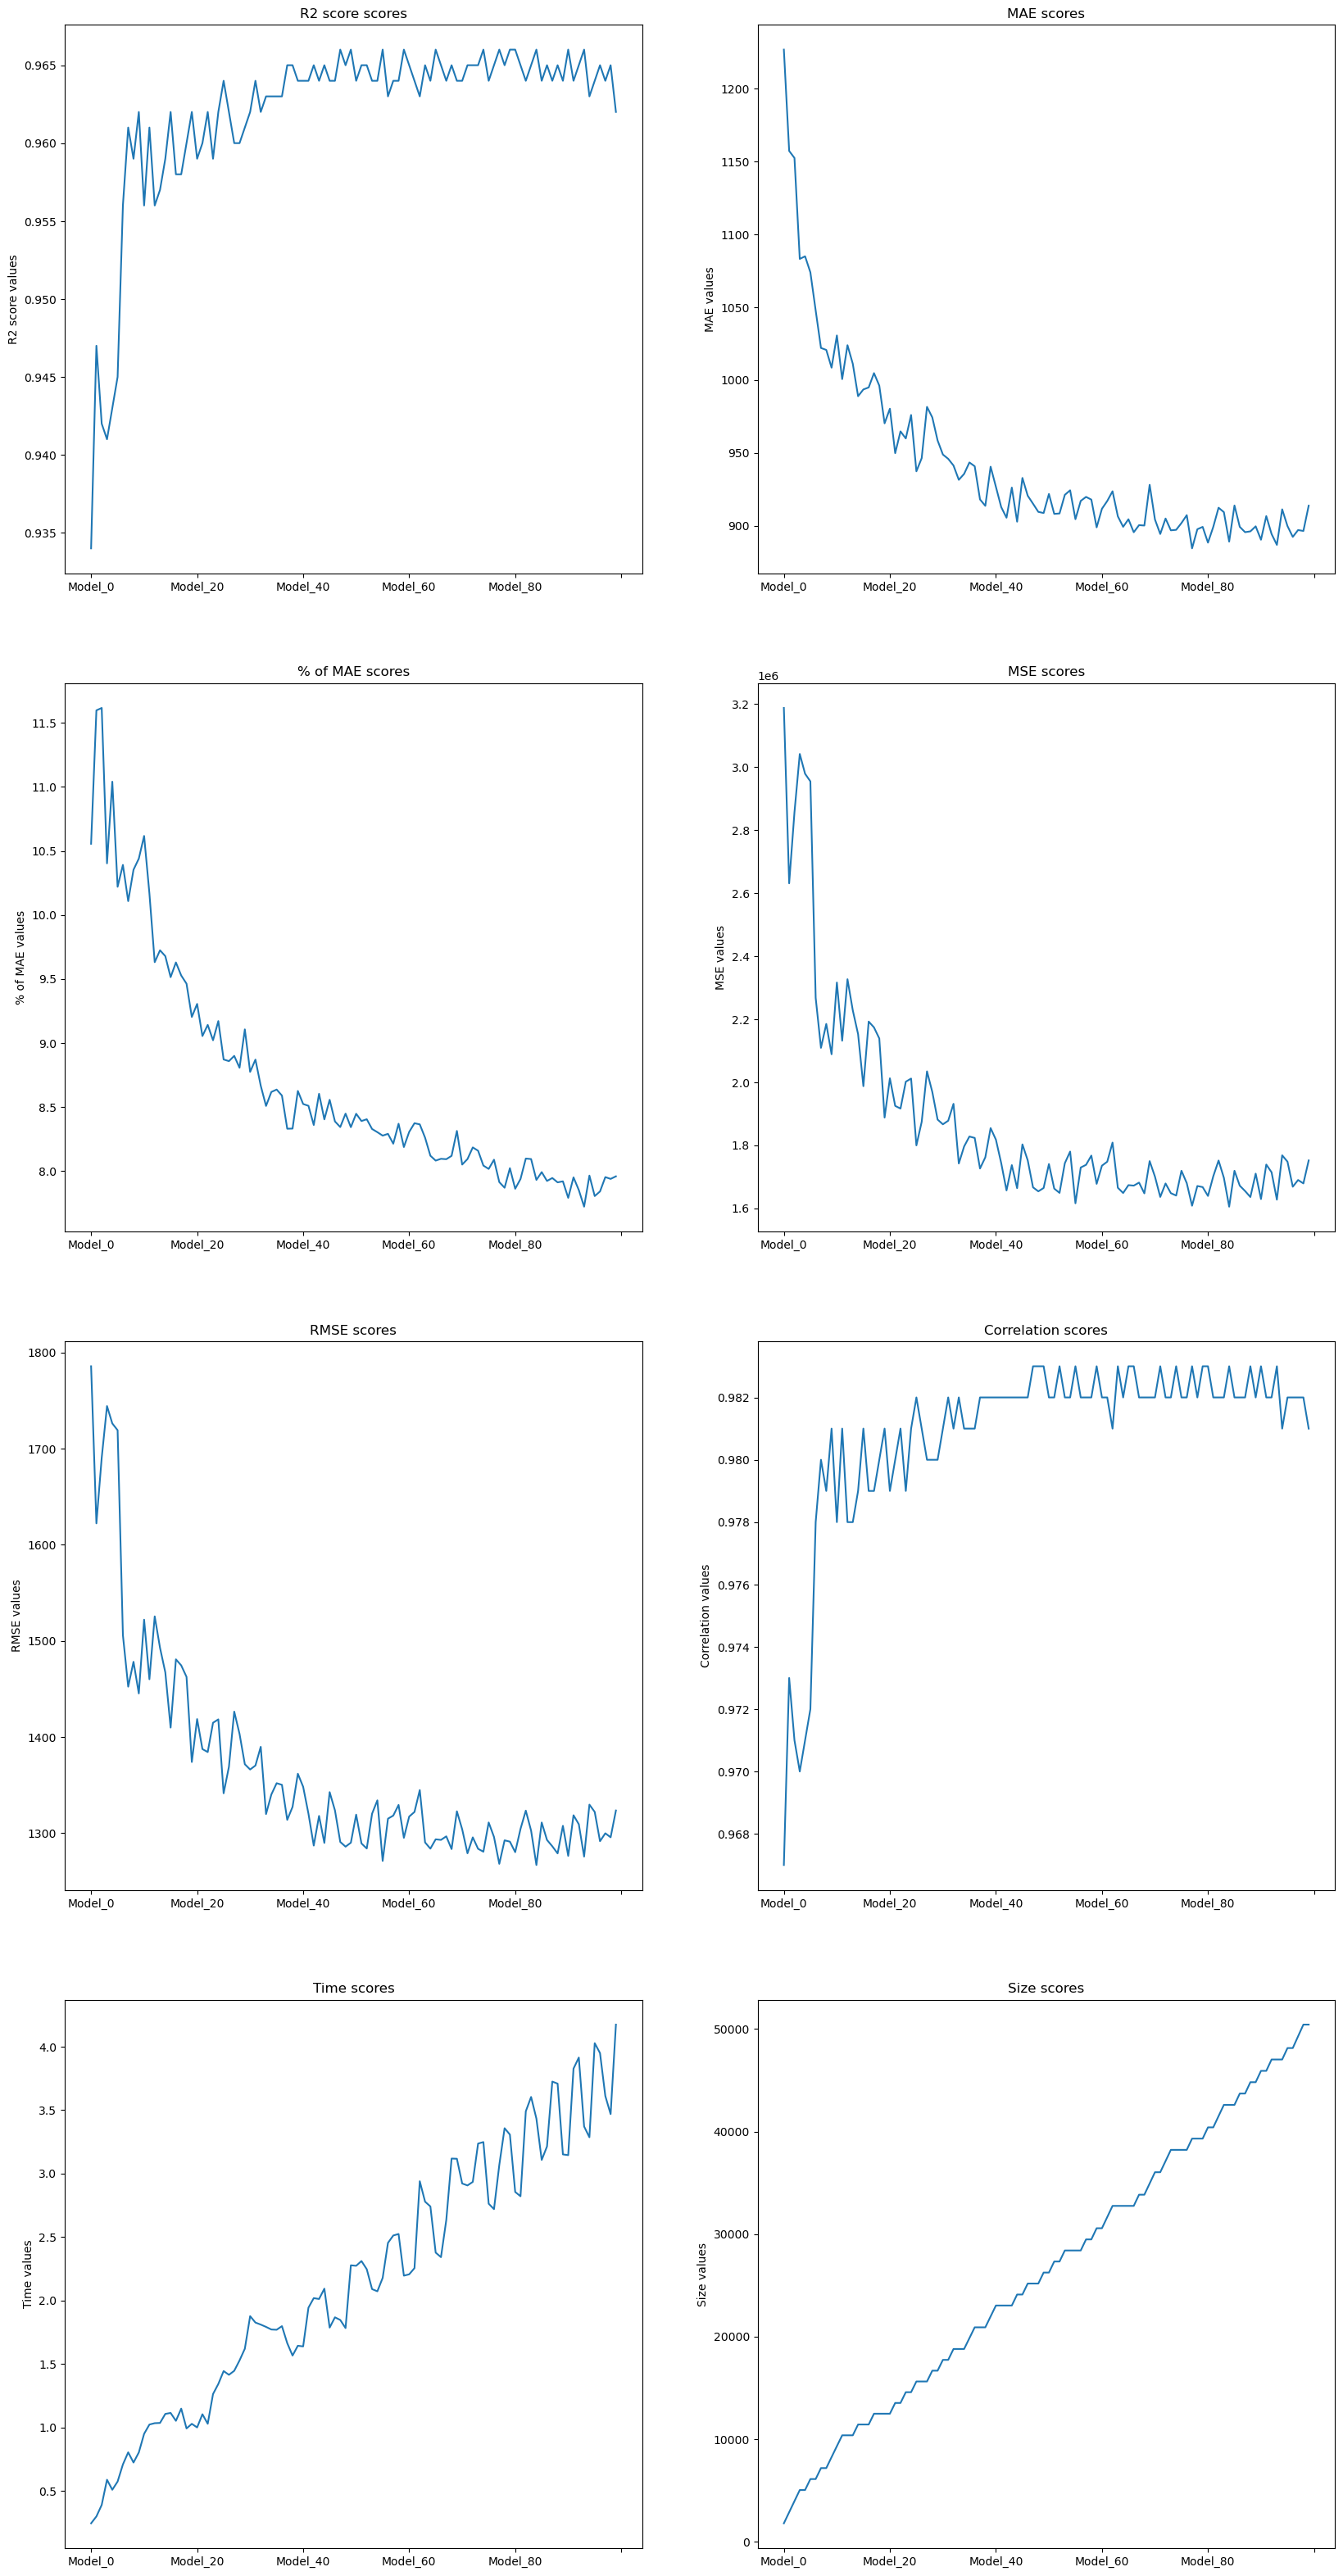

In [59]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp7.index):
    plt.subplot(4,2,i+1)
    df_scores_exp7.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [60]:
df_scores_exp7.to_excel('exp7_scores.xlsx')

In [61]:
joblib.dump(model, 'xgb_100')

['xgb_100']